In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import filter_data 
import imp
# from pandasql import sqldf
# from progressbar import ProgressBar


imp.reload(filter_data)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 99
import consts
imp.reload(consts)

C:\Users\Bengo\AppData\Local\Temp\ipykernel_15932\449086281.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<module 'consts' from 'd:\\Ben\\FinalDSProj\\consts.py'>

In [4]:
pd.options.display.max_rows = 100

In [2]:
df_inputs = pd.read_csv("filtered\\input_events_filtered_by_subject_id_and_medicine.csv")

In [3]:
unique_sids = df_inputs["subject_id"].unique()

In [4]:
def get_patient_noreadrenaline_tf(df, _subject_id, _stay_id):
    # if subject_id not in df["subject_id"].unique() or stay_id not in df["stay_id"].unique() or "Norepinephrine" not in df["itemid_label"].unique():
    #     return False
    return df[(df["subject_id"] == _subject_id) & (df["stay_id"] == _stay_id) & (df["itemid_label"] == "Norepinephrine")][["starttime", "endtime", "statusdescription", "originalrate", "itemid_label"]].sort_values(by="starttime")
    # return df[(df["subject_id"] == _subject_id) & (df["stay_id"] == _stay_id) & (df["itemid_label"] == "Norepinephrine")][["starttime", "endtime", "statusdescription", "originalrate", "itemid_label"]].sort_values(by="starttime")
    # return df[(df["subject_id"] == _subject_id) & (df["stay_id"] == _stay_id)][["starttime", "endtime", "statusdescription", "originalrate", "itemid_label"]].sort_values(by="starttime").copy()
    # return df[(df["subject_id"] == subject_id) & (df["stay_id"] == stay_id) & (df["itemid_label"] == "Norepinephrine")][["starttime", "endtime", "statusdescription", "originalrate"]].sort_values(by="starttime")
    

In [5]:
def count_overlaps(df, subject_id, stay_id):
    patient_noreadrenaline_tf = get_patient_noreadrenaline_tf(df, subject_id, stay_id)
    patient_inputs_without_ne = df[(df["subject_id"] == subject_id) & (df["stay_id"] == stay_id) & (df["itemid_label"] != "Norepinephrine")][["starttime", "endtime", "statusdescription", "originalrate"]].sort_values(by="starttime")
    counter = 0
    for event in patient_inputs_without_ne.itertuples():
        for noreadrenaline_event in patient_noreadrenaline_tf.itertuples():
            if event.starttime < noreadrenaline_event.endtime and event.endtime > noreadrenaline_event.starttime:
                counter += 1
    return counter

In [6]:
# create df with 3 columns
# overlaps_df = pd.DataFrame(columns=["subject_id", "stay_id", "overlaps"])
from tqdm import tqdm
import numpy as np

#sample n random unique subject_ids
random_sids = np.random.choice(unique_sids, size=2000, replace=False)
ls = []
for sid in tqdm(random_sids):
    stay_ids = df_inputs[df_inputs["subject_id"] == sid]["stay_id"].unique()
    for stay_id in stay_ids:
        ls.append({"subject_id": sid, "stay_id": stay_id, "overlaps": count_overlaps(df_inputs, sid, stay_id)})
overlaps_df = pd.DataFrame(ls)

  2%|▏         | 40/2000 [00:06<04:06,  7.97it/s]

: 

: 

<AxesSubplot:title={'center':'Amount of overlaps between recieving Norepinephrine\n and other inputs\n random 2000 subjects'}, xlabel='overlaps', ylabel='Count'>

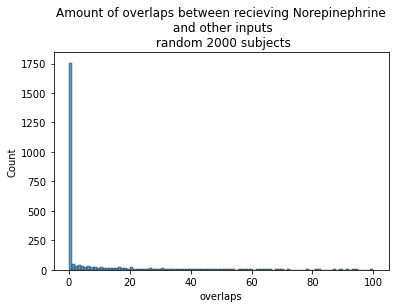

In [107]:
# plot overlaps
# set x limit to 100

# prctg of 0 overlaps
# overlaps_df[overlaps_df["overlaps"] == 0].shape[0] / ov
# erlaps_df.shape[0]
title = "Amount of overlaps between recieving Norepinephrine\n and other inputs\n random 2000 subjects"
plt.title(title)
sns.histplot(overlaps_df["overlaps"],binrange=[0,100])
# overlaps_df["overlaps"].value_counts()
# overlaps_df[overlaps_df["overlaps"] == 0].count() / random_sids.shape[0]

In [168]:
overlaps_df.to_csv("filtered\\overlaps_df.csv")

In [182]:
unique_stay_ids = df_inputs["stay_id"].unique()

In [222]:
def check_if_change_in_rate_greater_than_epsilon(stay_id, epsilon, status_description):
        input_for_patient = df_inputs[(df_inputs["stay_id"] == stay_id) & (df_inputs["statusdescription"] == status_description) &( df_inputs["itemid_label"] == "Norepinephrine")][["stay_id", "starttime", "endtime", "statusdescription", "originalrate", "rate", "itemid_label"]].sort_values(by="starttime")
        if input_for_patient.shape[0] == 0:
                return False
        previous_rate = input_for_patient.iloc[0]["originalrate"]
        previous_endtime = input_for_patient.iloc[0]["endtime"]
        for row in input_for_patient[1:].itertuples():
                if abs(row.originalrate - previous_rate) < epsilon and previous_endtime == row.starttime:
                        print("stay_id: {}, status_description: {}, rate: {}, originalrate: {}, starttime: {}, endtime: {}".format(stay_id, status_description, row.rate, row.originalrate, row.starttime, row.endtime))
                        return True
                previous_rate = row.originalrate
                previous_endtime = row.endtime
        return False

random_stay_id = np.random.choice(unique_stay_ids, size=2000, replace=False)
ls = []
# for stay_id in tqdm(random_stay_id):
#         ls.append(check_if_change_in_rate_greater_than_epsilon(stay_id, 0.001, "ChangeDose/Rate"))

In [216]:
# sum(ls)
indices = [i for i, x in enumerate(ls) if x == True]

In [217]:
indices

[1055, 1152, 1256, 1267, 1343, 1685, 1700]

In [218]:
random_stay_id[1055]

37918933

In [228]:
random_stay_id[1256]

35315630

In [224]:
check_if_change_in_rate_greater_than_epsilon(37918933, 0.001, "ChangeDose/Rate")

stay_id: 37918933, status_description: ChangeDose/Rate, rate: 0.1714181416900828, originalrate: 0.1689078360795974, starttime: 2178-09-02 08:08:00, endtime: 2178-09-02 08:11:00


True

In [206]:
indices = [i for i, x in enumerate(ls) if x == True]

## Overlaying MAP - Nor plot

In [118]:
example_patient_inputs = df_inputs[(df_inputs["stay_id"] == 35315630) &( df_inputs["itemid_label"] == "Norepinephrine")][["stay_id", "starttime", "endtime", "statusdescription", "originalrate", "rate", "itemid_label", "orderid"]].sort_values(by="starttime")

In [12]:
df_events = pd.read_csv("filtered\\filtered_chartevents.csv")
patient_example_events = df_events[df_events["stay_id"] == 35315630].copy()
del df_events

C:\Users\Bengo\AppData\Local\Temp\ipykernel_15932\3900722179.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_events = pd.read_csv("filtered\\filtered_chartevents.csv")


In [164]:
# df["InsertedDate"] = pd.to_datetime(df["InsertedDate"])
patient_example_events["charttime"] = pd.to_datetime(patient_example_events["charttime"])
# first_day = patient_example_events.sort_values(by="charttime")
first_day = patient_example_events[patient_example_events["charttime"].dt.date <= np.datetime64('2156-11-11')]
patient_example_events["time_from_addmission"] = patient_example_events["charttime"] - first_day["charttime"].iloc[0]
hr = first_day[first_day["itemid_label"] == "Heart Rate"].sort_values(by="time_from_addmission")
mean_bp = first_day[first_day["itemid_label"] == "Arterial Blood Pressure mean"].sort_values(by="time_from_addmission")
first_day_filtered =first_day[ (first_day["itemid_label"] == "Arterial Blood Pressure mean")].sort_values(by="time_from_addmission")

In [163]:
example_patient_inputs["starttime"] = pd.to_datetime(example_patient_inputs["starttime"])
example_patient_inputs["time_from_addmission"] = example_patient_inputs["starttime"] - first_day["charttime"].iloc[0]
example_patient_inputs_first_day= example_patient_inputs[example_patient_inputs["starttime"].dt.date <= np.datetime64('2156-11-11')].sort_values(by="time_from_addmission")

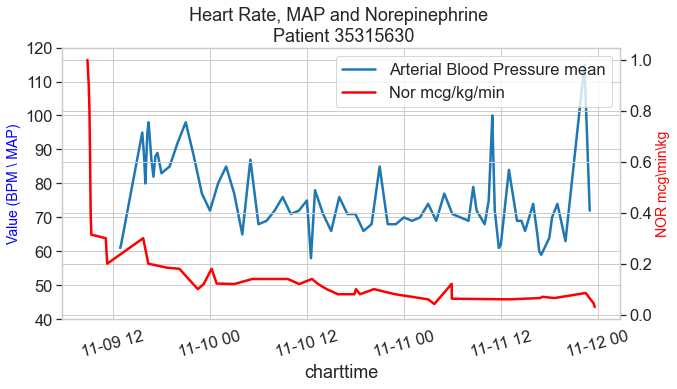

In [166]:
sns.set_style("whitegrid")
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.lineplot(x="charttime", y="value", data=first_day_filtered, hue="itemid_label")
ax.set(ylim=(40, 120))
plt.xticks(rotation=15)
ax.set_ylabel("Value (BPM \ MAP)", color="blue", fontsize=14)
ax.get_legend().remove()

ax2=ax.twinx()
ax2.plot(example_patient_inputs_first_day["starttime"], example_patient_inputs_first_day["originalrate"], "r", label="Nor mcg/kg/min")
ax2.set_ylabel("NOR mcg\min\kg",color="red",fontsize=14)
# add line to legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

# leg = ax2.legend(loc=0)
# plt.segt
ax.set_title("Heart Rate, MAP and Norepinephrine \n Patient 35315630")
plt.savefig("figures\\patient_35315630.png")
# plt.show()



In [132]:
ax.get_legend()